Little notebook to demonstrate generating synthetic data where the genes' activations depend on each other

In [1]:
from yeastdnnexplorer.probability_models.generate_data import (generate_gene_population, 
                                                               generate_binding_effects,
                                                               generate_pvalues,
                                                               perturbation_effect_adjustment_function_with_tf_relationships,
                                                               generate_perturbation_effects)

import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices

Generating the gene populations and binding effects is the same as before

In [2]:
n_genes = 1000
signal = [0.1, 0.15, 0.2, 0.25, 0.3]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for signal_proportion, n_draws in zip(signal, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, signal_proportion))

# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population)
                     for gene_population in gene_populations_list]

# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval
                         in zip (gene_populations_list, binding_effect_list, binding_pvalue_list)]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

print("Shape of binding_data_tensor: ", binding_data_tensor.shape)

Shape of binding_data_tensor:  torch.Size([1000, 10, 3])


Now, when we generate perturbation effects, we can pass in a map of dependencies between the TFs. For a specific gene, we only adjust its mean based off of TFs where the [gene, TF] point is both in the signal group for that TF's gene population AND if all of the TFs it depends on are in the signal group for that gene population. Make sure that max_mean_adjustment > 0 so that the adjustment function is used by generate_perturbation_effects.

In [3]:
tf_relationships = {
    0: [2, 4, 7],
    1: [8],
    2: [3, 9],
    3: [1, 6],
    4: [5],
    5: [0, 2, 8],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [0, 3, 8]
}


perturbation_effects_list = [generate_perturbation_effects(binding_data_tensor, tf_index=tf_index, max_mean_adjustment=15.0, tf_relationships=tf_relationships, adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships)
                             for tf_index in range(sum(n_sample))]

perturbation_pvalue_list = [generate_pvalues(perturbation_effects)
                            for perturbation_effects in perturbation_effects_list]



Data Assembly step is also the same as before

In [4]:
# Convert lists to tensors if they are not already
perturbation_effects_tensor = torch.stack(perturbation_effects_list, dim=1)
perturbation_pvalues_tensor = torch.stack(perturbation_pvalue_list, dim=1)

# Ensure perturbation data is reshaped to match [n_genes, n_tfs]
# This step might need adjustment based on the actual shapes of your tensors.
perturbation_effects_tensor = perturbation_effects_tensor.unsqueeze(-1)  # Adds an extra dimension for concatenation
perturbation_pvalues_tensor = perturbation_pvalues_tensor.unsqueeze(-1)  # Adds an extra dimension for concatenation

# Concatenate along the last dimension to form a [n_genes, n_tfs, 5] tensor
final_data_tensor = torch.cat((binding_data_tensor, perturbation_effects_tensor, perturbation_pvalues_tensor), dim=2)

# Verify the shape
print("Shape of the final data tensor:", final_data_tensor.shape)

Shape of the final data tensor: torch.Size([1000, 10, 5])


Showing the difference between using the two adjustment functions

Shape of perturbation_effects_tensor_dep_adjust:  torch.Size([1000, 10, 1])
Signal vs noise for the third gene
[0. 1. 0. 0. 1. 0. 0. 1. 0. 1.]
tf relationships
{0: [2, 4, 7], 1: [4], 2: [3, 9], 3: [4], 4: [7], 5: [0, 2, 8], 6: [4], 7: [9], 8: [9], 9: [0]}


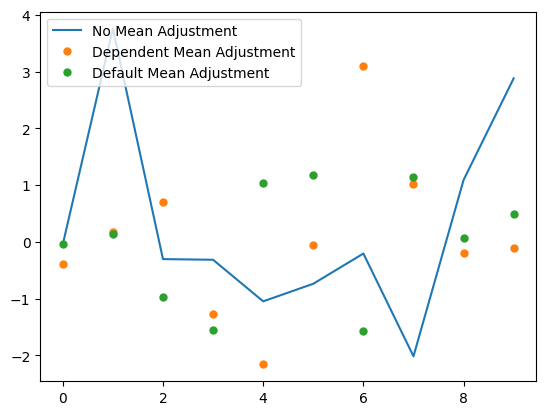

In [16]:
# tf_relationships = {
#     0: [2, 4, 7],
#     1: [8],
#     2: [3, 9],
#     3: [4],
#     4: [5],
#     5: [0, 2, 8],
#     6: [4],
#     7: [8],
#     8: [9],
#     9: [0, 3, 8]
# }

tf_relationships = {
    0: [2, 4, 7],
    1: [4],
    2: [3, 9],
    3: [4],
    4: [7],
    5: [0, 2, 8],
    6: [4],
    7: [9],
    8: [9],
    9: [0]
}


perturbation_effects_list_dependent_adjustment = [generate_perturbation_effects(binding_data_tensor, tf_index=tf_index, max_mean_adjustment=15.0, tf_relationships=tf_relationships, adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships)
                             for tf_index in range(sum(n_sample))]

# Convert lists to tensors if they are not already
perturbation_effects_tensor_dep_adjust_tensor = torch.stack(perturbation_effects_list_dependent_adjustment, dim=1)
perturbation_effects_tensor_dep_adjust = perturbation_effects_tensor_dep_adjust_tensor.unsqueeze(-1)  # Adds an extra dimension for concatenation
                             
perturbation_effects_list_default_adjustment = [generate_perturbation_effects(binding_data_tensor, tf_index=tf_index, max_mean_adjustment=15.0)
                             for tf_index in range(sum(n_sample))]

perturbation_effects_tensor_default_adjust_tensor = torch.stack(perturbation_effects_list_default_adjustment, dim=1)
perturbation_effects_tensor_default_adjust = perturbation_effects_tensor_default_adjust_tensor.unsqueeze(-1)  # Adds an extra dimension for concatenation

# debugging: REMOVE ================================================================= 
    # this shows that the data generation is random, is there a way to make it deterministic?
    # beacuse the perturb effects with default adjustment are different when I replicate with the below 3 lines of code

# perturbation_effects_list_default_adjustment2 = [generate_perturbation_effects(binding_data_tensor, tf_index=tf_index, max_mean_adjustment=15.0)
#                              for tf_index in range(sum(n_sample))]
# perturbation_effects_tensor_default_adjust_tensor2 = torch.stack(perturbation_effects_list_default_adjustment2, dim=1)
# perturbation_effects_tensor_default_adjust2 = perturbation_effects_tensor_default_adjust_tensor2.unsqueeze(-1)  # Adds an extra dimension for concatenation
# debugging: REMOVE ================================================================= 

perturbation_effects_list_no_adjustment = [generate_perturbation_effects(binding_data_tensor, tf_index=tf_index, max_mean_adjustment=0.0)
                                           for tf_index in range(sum(n_sample))]

perturbation_effects_tensor_no_adjustment_tensor = torch.stack(perturbation_effects_list_no_adjustment, dim=1)
perturbation_effects_tensor_no_adjustment = perturbation_effects_tensor_no_adjustment_tensor.unsqueeze(-1)  # Adds an extra dimension for concatenation

print("Shape of perturbation_effects_tensor_dep_adjust: ", perturbation_effects_tensor_dep_adjust.shape)

# print("Perturbation Effects with no mean adjustment")
# print(perturbation_effects_tensor_no_adjustment[0][:].numpy())

# print("Perturbation effects with dependent adjustment for first gene")
# print(perturbation_effects_tensor_dep_adjust[0][:].numpy())

# print("Perturbation effects with default adjustment for first gene")
# print(perturbation_effects_tensor_default_adjust[0][:].numpy())

print("Signal vs noise for the third gene")
print(binding_data_tensor[2, :, 0].numpy())

print("tf relationships")
print(tf_relationships)

# Plot the perturbation effects for the first gene (unadjusted, dependent adjustment, default adjustment)
plt.figure()
plt.plot(perturbation_effects_tensor_no_adjustment[2][:].numpy(), label="No Mean Adjustment")
plt.plot(perturbation_effects_tensor_dep_adjust[2][:].numpy(), '.', markersize=10, label="Dependent Mean Adjustment")
plt.plot(perturbation_effects_tensor_default_adjust[2][:].numpy(), '.', markersize=10, label="Default Mean Adjustment")
# plt.plot(perturbation_effects_tensor_default_adjust2[2][:].numpy(), '.', markersize=10, label="Default Mean Adjustment Double Check")
plt.legend()
plt.show()